In [43]:
import os
import sys

# Get the directory of the current file
current_dir = os.path.dirname(os.path.realpath('__file__'))

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to the system path
sys.path.insert(0, parent_dir)
import numpy as np              # Python's standard numerical library
import matplotlib.pyplot as plt # Python's scientific visualization library
import pyidi                    # Python HSC data analysis library
import pickle as pk
from pixel_setter2 import PixelSetter#, play_video, detect_peaks
from pixel_setter import play_video
from scipy.ndimage import uniform_filter
import importlib
from EMA_functions import *
from Feature_selecter import *
import matplotlib.animation as animation
from pyidi import ROISelect
from matplotlib.path import Path
import scipy.io
import cv2
import pyoma2 as oma
from skimage.color import rgb2gray
root_drive_sim = os.path.normpath('G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Research Projects/Spiders/Simulations')

Convert .mat video to .mp4

In [63]:
mat_root = r'D:\thijsmas'
mat_file_name = 'MSSP_2017_3story_video.mat'
mat_file = os.path.join(mat_root, mat_file_name)
data = scipy.io.loadmat(mat_file)
rgb_frames = data['vid']  # Assuming shape is (384, 216, 3, 1721)

# Weights for the RGB channels
# weights = np.array([0.2989, 0.5870, 0.1140])

# Convert to greyscale
# greyscale_frames = np.dot(rgb_frames.reshape(-1, 3), weights).reshape(384, 216, 1721)
greyscale_frames = np.array([rgb2gray(rgb_frames[:, :, :, i]) * 255 for i in range(rgb_frames.shape[3])]).astype(np.uint8)

# Flip greyscale_frames to have shape (1721, 384, 216)
# flipped_greyscale_frames = np.transpose(greyscale_frames, (2, 0, 1))

# Plot the first frame to check
plt.imshow(greyscale_frames[0], cmap='gray')
plt.title("First Frame")
plt.show()

In [64]:
# file_name = 'MSSP_2017_3story_video.mp4'
root_idi = r'D:\thijsmas\MSSP_replication'
EMA_structure = EMA_Structure('no_file')
# video = EMA_structure.open_video(add_extension = False)
video = pyidi.pyIDI(greyscale_frames, root=root_idi)
bit_depth = 8

In [65]:
%matplotlib qt
sequential_image_n = 1
# still_image = video.mraw[sequential_image_n]
still_image = video.reader.get_frame(sequential_image_n)

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=False, bit_depth=8)

still_image


array([[63, 60, 62, ..., 52, 52, 50],
       [57, 58, 59, ..., 49, 48, 48],
       [56, 57, 58, ..., 49, 47, 47],
       ...,
       [92, 92, 92, ..., 81, 79, 80],
       [92, 91, 91, ..., 83, 82, 80],
       [89, 89, 88, ..., 84, 85, 84]], dtype=uint8)

In [66]:
# roi_select = ROISelect(video)
# roi_select.polygon
# polygon_new = np.array(roi_select.polygon)

polygon = np.array([[ 28,  26,  43,  46, 125, 126, 145, 147, 224, 227, 248, 249, 324,
        340, 339, 329, 248, 248, 229, 228, 151, 150, 126, 125,  51,  28],
       [  8, 207, 207, 198, 198, 204, 207, 197, 201, 207, 208, 199, 203,
        200,  19,  19,  19,  12,   9,  16,  12,   8,   6,  14,   7,   8]])
path = Path(polygon.T)


In [67]:
roi_size = (9,9)
reference_image = (0,1)
mean_image      = np.mean(video.mraw[reference_image[0]:reference_image[1]], axis=0)

C:\Users\thijsmas\Documents\GitHub\pyidi\pyidi\pyidi.py:275: DeprecationWarning: `self.mraw` is deprecated and will be removed in the next version. Please use `self.reader.mraw` instead.
  warnings.warn('`self.mraw` is deprecated and will be removed in the next version. Please use `self.reader.mraw` instead.', DeprecationWarning)


In [68]:
%matplotlib qt
roi_size = (9,9) 
n_tracking_points = 300
processors = 12

reference_image = (0,1)
mean_image      = np.mean(video.mraw[reference_image[0]:reference_image[1]], axis=0)

feature_selecter = FeatureSelecter(still_image)
feature_selecter.set_filter_method('eig0', roi_size)
score_full = feature_selecter.apply_filter(downsample=1)

mask_image = path.contains_points(np.array([(i,j) for i in range(mean_image.shape[0]) for j in range(mean_image.shape[1])])).reshape(mean_image.shape)
mask_image = mask_image.reshape(mean_image.shape)

score_full[~mask_image] = 0
score_full[mean_image >= int(0.99*(2**bit_depth-1))] = 0

# maxima2d = feature_selecter.pick_max_filter(score_image = None, min_distance = 3, absolute_treshold = None, threshold_percentage = 20, top_n_points = n_tracking_points)
maxima2d = feature_selecter.pick_max_loop(score_image = None, min_distance = (5,5), n_points = n_tracking_points)
score_list = score_full[maxima2d[:, 0], maxima2d[:, 1]]
feature_selecter.plot_score_image(maxima=False)

fig, ax = plt.subplots(1, 1, figsize=(15, 7.5))
fig.set_tight_layout(True)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(mean_image, cmap='gray')
ax.scatter(maxima2d[:,1], maxima2d[:,0], marker='o',s=10, c=score_list, cmap='RdYlGn')
ax.plot(polygon[1], polygon[0], color='k', lw=0.5)
plt.close()
video.set_method('lk')
video.method.configure(roi_size = roi_size, reference_image = reference_image,  resume_analysis=False) #, mraw_range=(1, 1000)
video.set_points(maxima2d)
video.show_points()
# displacement = video.get_displacements(processes = processors)


Available filter methods: eig0, eig1, harris, trigs, harmonic_mean, eig_theta, eig_theta_off, eig0_test, eig1_test


C:\Users\thijsmas\AppData\Local\Temp\ipykernel_38216\3175384713.py:25: PendingDeprecationWarning: The set_tight_layout function will be deprecated in a future version. Use set_layout_engine instead.
  fig.set_tight_layout(True)


In [85]:
%matplotlib qt
roi_size = (9,5)
processors = 1
reference_image = (0, video.reader.N)
mean_image      = np.mean(video.mraw[reference_image[0]:reference_image[1]], axis=0)
# roi_size_1d = (15, 15)
n_tracking_points = 500 # 600
Gi, Gj = np.gradient(mean_image)
s = np.array([1,0])
Gs  = np.abs(s[1]*Gi + s[0]*Gj)
dyx = (0, 1)
smoothing_size = (1,1)

feature_selecter = FeatureSelecter(still_image)
filtered_image = uniform_filter(Gs, size=roi_size)

mask_image = path.contains_points(np.array([(i,j) for i in range(mean_image.shape[0]) for j in range(mean_image.shape[1])])).reshape(mean_image.shape)
mask_image = mask_image.reshape(mean_image.shape)

filtered_image[~mask_image] = 0
filtered_image[mean_image >= int(0.99*(2**bit_depth-1))] = 0

# maxima1d = feature_selecter.pick_max_filter(score_image = filtered_image, min_distance = 3, absolute_treshold = None, threshold_percentage = None, top_n_points = n_tracking_points)
maxima1d = feature_selecter.pick_max_loop(score_image = filtered_image, min_distance = (3,3), n_points = n_tracking_points, minimum_score= 1)
score_list = filtered_image[maxima1d[:, 0], maxima1d[:, 1]]
feature_selecter.score_image = filtered_image
feature_selecter.plot_score_image(maxima=False)

fig, ax = plt.subplots(1, 1, figsize=(15, 7.5))
fig.set_tight_layout(True)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(mean_image, cmap='gray')
ax.scatter(maxima1d[:,1], maxima1d[:,0], marker='o',s=10, c=score_list, cmap='RdYlGn')
ax.plot(polygon[1], polygon[0], color='k', lw=0.5)

video.set_method('lk_1D')
video.method.configure(roi_size = roi_size, dyx = dyx, reference_image = reference_image,  resume_analysis=False, smoothing_size = smoothing_size, tol=1e-20, max_nfev = 30) #, mraw_range=(1, 1000)
video.set_points(maxima1d)
video.show_points()
# displacement = video.get_displacements(processes = processors)
roi_size = (11,5)
video.method.configure(roi_size = roi_size, dyx = dyx, reference_image = reference_image,  resume_analysis=False, smoothing_size = smoothing_size, tol=1e-20, max_nfev = 30) #, mraw_range=(1, 1000)
displacement = video.get_displacements(processes = processors)

Available filter methods: eig0, eig1, harris, trigs, harmonic_mean, eig_theta, eig_theta_off, eig0_test, eig1_test


C:\Users\thijsmas\AppData\Local\Temp\ipykernel_38216\2340613086.py:30: PendingDeprecationWarning: The set_tight_layout function will be deprecated in a future version. Use set_layout_engine instead.
  fig.set_tight_layout(True)


--- Starting new analysis ---
 
Interpolating the reference image...
...done in 0.21 s


VBox()

C:\Users\thijsmas\Documents\GitHub\pyidi\pyidi\methods\_directional_lucas_kanade.py:358: UserWarning: Reached image edge. The displacement optimization algorithm may not converge, or selected points might be too close to image border. Please check analysis settings.
  warnings.warn('Reached image edge. The displacement optimization ' +


Time to complete: 39 min, 57.7 s
D:\thijsmas\MSSP_replication\ndarary_video_pyidi_analysis\analysis_010\ analysis_010


In [86]:
# test = 5
# test_name = 'analysis_' + str(test).zfill(3)
# # with open(os.path.join(video.root, file_name_vec[0] +'_S01_pyidi_analysis', test_name,  'points.pkl'), 'rb') as f:
# #     maxima_2d = pk.load(f)
# # with open(os.path.join(video.root, file_name_vec[0] +'_S01_pyidi_analysis', test_name, 'results.pkl'), 'rb') as f:
# #     displacements2D_2Dpoints = pk.load(f)
# with open(os.path.join(video.root, file_name_vec[0] +'_S01_pyidi_analysis', test_name, 'settings.txt'), 'r') as f:
#     settings_2d = f.read()

test = 11
test_name = 'analysis_' + str(test).zfill(3)
with open(os.path.join(root_idi, 'ndarary_video_pyidi_analysis', test_name,  'points.pkl'), 'rb') as f:
    maxima1d = pk.load(f)
with open(os.path.join(root_idi, 'ndarary_video_pyidi_analysis', test_name, 'results.pkl'), 'rb') as f:
    displacement = pk.load(f)
with open(os.path.join(root_idi, 'ndarary_video_pyidi_analysis', test_name, 'settings.txt'), 'r') as f:
    settings_1d = f.read()
settings_1d

EMA_structure.d = displacement #- np.mean(displacement, axis=1)[:, np.newaxis]
n_tracking_points = len(maxima1d)

In [87]:
%matplotlib qt
td     = displacement +  maxima1d.reshape(len(maxima1d),1,2)
# td_saved    = disp_save[::100] + points[::100].reshape(len(points[::100]),1,2)
# td1d_2d     = displacements1D_2Dpoints +  maxima2d.reshape(len(maxima2d),1,2)
ani = play_video(video, range(200, 500-1), interval=10, points=td, axis=([0, video.reader.image_width],[video.reader.image_height, 0]))
# ani_saved = play_video(video, range(200, 500-1), interval=10, points=td_saved, axis=([0, video.info['Image Width']],[video.info['Image Height'], 0]))

(-5.0, 5.0)

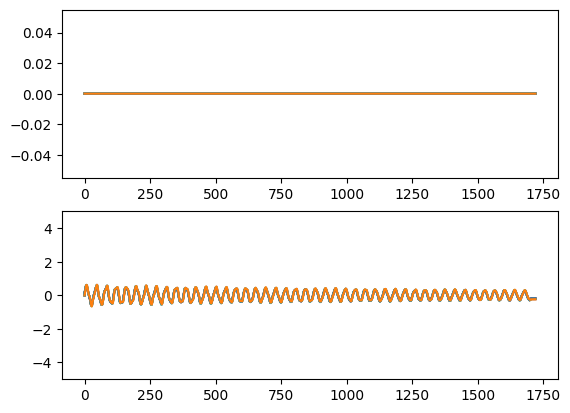

In [75]:
%matplotlib inline
fig, ax = plt.subplots(2)
for d_i in displacement:
    ax[0].plot(d_i[:,0])
    ax[1].plot(d_i[:,1])
ax[1].set_ylim(-5, 5)
# ax[1].set_xlim(250, 500)

In [88]:
d_lim = 8
d_min = 0.1
smooth_lim = 1
max_drift = 2   
max_end_drift = 1.5

EMA_structure.initialize_displacement(idx='all', dir='xy')
EMA_structure.exclude_tp(d_lim)
EMA_structure.valid_tps = EMA_structure.exclude_high_amplitude & (np.max(np.linalg.norm(EMA_structure.d, axis=2),1) > d_min)

smooth_signals = np.max(np.abs(np.diff(np.linalg.norm(EMA_structure.d, axis=2))), axis = 1) < smooth_lim

non_drifting = np.abs(np.mean(np.linalg.norm(EMA_structure.d[:,:-100], axis=2), axis=1) < max_drift)
non_drifting2 = np.abs(np.linalg.norm(EMA_structure.d[:,-1], axis=1)) < max_end_drift


EMA_structure.valid_tps = EMA_structure.valid_tps  & smooth_signals & non_drifting & non_drifting2

ani = play_video(video, range(200, 500-1), interval=10, points=td[EMA_structure.valid_tps], axis=([0, video.reader.image_width],[video.reader.image_height, 0]))

EMA_structure.valid_tps.sum(), EMA_structure.exclude_high_amplitude.sum(), smooth_signals.sum() , non_drifting.sum(),  non_drifting2.sum(), (np.max(np.linalg.norm(EMA_structure.d, axis=2),1) > d_min).sum()

(456, 499, 498, 499, 500, 458)

In [90]:
%matplotlib qt
window_size = 15  # Define the window size for the rolling average
window = np.ones(window_size) / window_size

n = video.reader.N
fs = 240        # Sampling frequency
dt = 1/fs       # Time step
T = dt*n    # acquisition time

freq = np.fft.rfftfreq(n, dt)
df = fs/n
Displacement = np.fft.rfft(EMA_structure.d[EMA_structure.valid_tps,:,1], n=n, axis=1) / n
Displacement[1:] *= 2
S_xx = 1/T * np.conj(Displacement) * Displacement
S_xx_rolling = scipy.ndimage.convolve1d(np.abs(S_xx), window, axis=1, mode='reflect')
peaks_local = []
for S_xx_rolling_i in S_xx_rolling:
    peaks_local.append(find_peaks(np.log10(S_xx_rolling_i), distance=15, prominence=1)[0])
S_xx = np.mean(S_xx, axis=0)
S_xx_rolling = np.mean(S_xx_rolling, axis=0)
peaks_global, _ = find_peaks(np.log10(S_xx_rolling), distance=10, prominence=1)
peaks_global = peaks_global[0]

# Function to check if a value is in an array within a margin
def is_in_array_with_margin(value, array, margin=4):
    return np.any(np.abs(array - value) <= margin)

valid_peaks = np.zeros(len(peaks_local), dtype=bool)
for peak_i, peak in enumerate(peaks_local):
    for p in peak:
        if is_in_array_with_margin(p, peaks_global):
            valid_peaks[peak_i] = True

valid_peaks2 = np.ones(n_tracking_points, dtype=bool)
valid_peaks2[EMA_structure.valid_tps] = valid_peaks
            
hann = np.hanning(n)
d_hann = EMA_structure.d[EMA_structure.valid_tps,:,1] * hann.reshape(1, n)
Displacement_hann = np.fft.rfft(d_hann, n=n, axis=1) / n
Displacement_hann[1:] *= 2
S_xx_hann = 1/T * np.conj(Displacement_hann) * Displacement_hann
S_xx_hann = np.mean(S_xx_hann, axis=0)

hamming = np.hamming(n)
d_hamming = EMA_structure.d[EMA_structure.valid_tps,:,1] * hamming.reshape(1, n)
Displacement_hamming = np.fft.rfft(d_hamming, n=n, axis=1) / n
Displacement_hamming[1:] *= 2
S_xx_hamming = 1/T * np.conj(Displacement_hamming) * Displacement_hamming
S_xx_hamming = np.mean(S_xx_hamming, axis=0)

bartlett = np.bartlett(n)
d_bartlett = EMA_structure.d[EMA_structure.valid_tps,:,1] * bartlett.reshape(1, n)
Displacement_bartlett = np.fft.rfft(d_bartlett, n=n, axis=1) / n
Displacement_bartlett[1:] *= 2
S_xx_bartlett = 1/T * np.conj(Displacement_bartlett) * Displacement_bartlett
S_xx_bartlett = np.mean(S_xx_bartlett, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(15, 7.5))
ax.semilogy(freq, np.abs(S_xx), label='No window')
# ax.semilogy(freq, np.abs(S_xx_hann), label='Hanning window')
# ax.semilogy(freq, np.abs(S_xx_hamming), label='Hamming window')
# ax.semilogy(freq, np.abs(S_xx_bartlett), label='Bartlett window')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
ax.set_ylim(1e-9, 1e-1)

# Add the rolling average to the plot
# ax.semilogy(freq, S_xx_rolling, label='Rolling average (convolution)')
ax.scatter(freq[peaks_global], S_xx_rolling[peaks_global], color='red', label='Peaks')
ax.legend()

print(valid_peaks2.sum(), EMA_structure.valid_tps.sum(), (valid_peaks2 & EMA_structure.valid_tps).sum())

EMA_structure.valid_tps = valid_peaks2 & EMA_structure.valid_tps

Displacement = np.fft.rfft(EMA_structure.d[EMA_structure.valid_tps,:,1], n=n, axis=1) / n
Displacement[1:] *= 2
S_xx_valid = 1/T * np.conj(Displacement) * Displacement
S_xx_valid = np.mean(S_xx_valid, axis=0)

ax.semilogy(freq, np.abs(S_xx_valid), label='Valid peaks')

499 456 455


In [34]:
%matplotlib qt
ani = play_video(video, range(1, video.reader.N-1,2), interval=10, points=td[EMA_structure.valid_tps], axis=([0, video.reader.image_width],[video.reader.image_height, 0]))



C:\Users\thijsmas\Documents\GitHub\pyidi\pyidi\pyidi.py:275: DeprecationWarning: `self.mraw` is deprecated and will be removed in the next version. Please use `self.reader.mraw` instead.
  warnings.warn('`self.mraw` is deprecated and will be removed in the next version. Please use `self.reader.mraw` instead.', DeprecationWarning)


(0.0, 20.0)

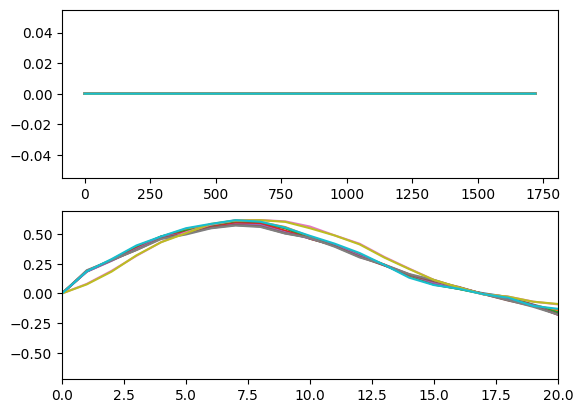

In [89]:
%matplotlib inline
fig, ax = plt.subplots(2)
for d_i in displacement[EMA_structure.valid_tps][:10]:
    ax[0].plot(d_i[:,0])
    ax[1].plot(d_i[:,1])
# ax[1].set_ylim(-5, 5)
ax[1].set_xlim(0, 20)